In [1]:
from models import VGAE
from utils import BrainGraphDataset
import torch
import os
from torch.utils.data import random_split
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

annotations = 'annotations.csv'
dataroot = 'fc_matrices/hcp_100_ica/'
cwd = os.getcwd() + '/'

hcp_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + dataroot + annotations,
                            transform=None, extra_data=None, setting='lz')

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=None, setting='lz')

from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

train_prop = 0.8

# split the psilo dataset into training and validation sets

num_psilo_samples = len(psilo_dataset)
psilo_train_size = int(train_prop * num_psilo_samples)
psilo_val_size = num_psilo_samples - psilo_train_size
train_set, val_set = random_split(psilo_dataset, [psilo_train_size, psilo_val_size])

# Create the mixed class loader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=0, pin_memory=True)


# define the hyperparameters
nf = 1
ef = 1
num_nodes = 100  # size of the graph adjacency matrix
hidden_dim = 64
latent_size = 4
lr = 1e-3

loss_curves = {}

# for dropout in [0.05]:
#     model = VGAE(nf, ef, num_nodes, hidden_dim, latent_size, device, dropout=dropout).to(device)  # move model to device
#     model.load_state_dict(torch.load(f'vgae_weights/vgae_first_working_{dropout}.pt', map_location=device))
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     # for json dump
#     best_val_loss = float('inf')  # set to infinity to start
#     best_model_state = None
#     train_losses = []
#     val_losses = []

#     # to reconstruct graph
#     src, dest = model.edge_index

#     num_epochs = 1000
#     for epoch in tqdm(range(num_epochs)):
#         train_loss = 0.0
#         val_loss = 0.0

#         # training
#         model.train()
#         for batch_idx, ((graph, lz, _), _) in enumerate(train_loader):
#             graph = graph.to(device)  # move data to device
#             lz = lz.to(device)
#             optimizer.zero_grad()

#             rcn_lz, rcn_edges, z = model(lz, graph)
#             graph = graph[:, src, dest]

#             (mse_loss, im_loss, l2_loss) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, z)
#             loss = mse_loss + im_loss + l2_loss
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         # validation
#         model.eval()
#         with torch.no_grad():
#             for batch_idx, ((graph, lz, _), _) in enumerate(val_loader):
#                 graph = graph.to(device)  # move data to device
#                 lz = lz.to(device)
#                 optimizer.zero_grad()

#                 rcn_lz, rcn_edges, z = model(lz, graph)
#                 graph = graph[:, src, dest]

#                 (mse_loss, im_loss, l2_loss) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, z)
#                 loss = mse_loss + im_loss + l2_loss
#                 val_loss += loss.item()
#         # append losses to lists
#         train_losses.append(train_loss/len(train_set))
#         val_losses.append(val_loss/len(val_set))

#         # save the model if the validation loss is at its minimum
#         if val_losses[-1] < best_val_loss:
#             best_val_loss = val_losses[-1]
#             best_model_state = model.state_dict().copy()

#         # print the losses
#         if (epoch + 1) % 100 == 0 :
#             with open('dropout_train.txt', 'a') as f:
#                 print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')
#                 f.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

#     # save the best model for this configuration
#     torch.save(best_model_state, f'vgae_weights/vgae_fine_tune_{dropout}.pt')

#     # add the loss curves to the dictionary
#     loss_curves[f"dropout_{dropout}"] = {"train_loss": train_losses, "val_loss": val_losses}

#     import json
#     # save the loss curves to a file
# with open("loss_curve_fine_tune_vgae_reg.json", "w") as f:
#     json.dump(loss_curves, f)

cpu


KeyError: 'dropout_0.1'

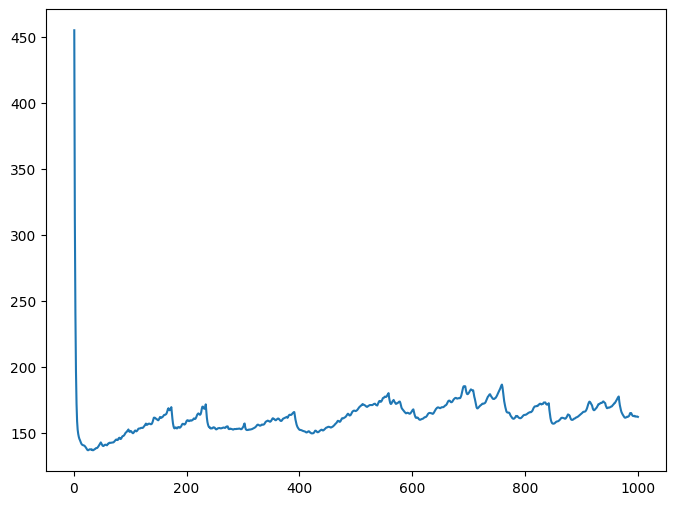

In [2]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curve_fine_tune_vgae_reg.json", "r") as f:
    loss_curves = json.load(f)

for dropout in [0.05, 0.1, 0.2]:
    val_losses = loss_curves[f'dropout_{dropout}']['val_loss']
    # plot the validation loss curves for each number of GMM components
    plt.figure(figsize=(8, 6))

    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"Val")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.ylim((0, 375))

# show the plot
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curve_fine_tune_vgae_reg.json", "r") as f:
    loss_curves = json.load(f)

train_losses = loss_curves['train_curve']
# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Train")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss Curves")
plt.legend()
plt.ylim((0, 850))

# show the plot
plt.show()

In [ ]:
# load in the models and get the validation loss for each
models = []
val_losses = []
l2_strength = 0.01
dropout = 0.05

# instantiate the model
model = VGAE(nf, ef, num_nodes, hidden_dim, latent_size, device, dropout=dropout).to(device)  # move model to device

# load the weights
model.load_state_dict(torch.load(f'vgae_weights/vgae_fine_tune.pt', map_location=device))

# set the model to evaluation mode
model.eval()

# calculate the validation loss
val_loss = 0.0
with torch.no_grad():
    for batch_idx, ((graph, lz, _), _) in enumerate(val_loader):
        graph = graph.to(device)  # move data to device
        lz = lz.to(device)
        optimizer.zero_grad()

        rcn_lz, rcn_edges, z = model(lz, graph)
        graph = graph[:, src, dest]

        (mse_loss, im_loss, l2_loss) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, z)
        loss = mse_loss + im_loss + l2_loss
        val_loss += loss.item()
val_loss /= len(val_set)

# print the validation loss for each model
print(f'Validation Loss = {val_loss:.4f}')

In [ ]:
import matplotlib.pyplot as plt
from nilearn import plotting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGAE(1, 1, 100, 64, 8, device).to(device)  # move model to device
model.load_state_dict(torch.load(f'vgae_weights/vgae_fine_tune_0.05.pt', map_location=device))

# select a batch from the validation data loader
data, _ = next(iter(val_loader))

for j in range(min(batch_size, 5)):
    # pass the batch through the trained model to obtain the reconstructed output
    (graph, lz, _) = data
    graph = graph[j:j+1].to(device)
    lz = lz[j:j+1].to(device)

    recon_x, recon_edges, z = model(lz, graph)

    recon_edges = recon_edges.detach()

    # Create a SparseTensor object from the edge_index and edge_attr tensors
    recon = torch.zeros((100, 100))

    for i in range(model.edge_index.shape[1]):
        recon[model.edge_index[0,i], model.edge_index[1,i]] = recon_edges[0][i]
        recon[model.edge_index[1,i], model.edge_index[0,i]] = recon_edges[0][i]

    # reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)

    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(graph.cpu().view(100, 100), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon.detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()